## 8-7. 프로젝트: 한영 번역기 만들기


## 개념 정리
### Bahdanau Attention

attention은 모든 인코더의 hidden state 값을 디코더에 제공한다. 이를 통해 모델이 입력된 문장의 유용한 부분에 집중하게 되므로 모델 간의 얼라인먼트(alignment: 원본 텍스트의 단어를 번역의 해당 단어와 일치시키는 것)을 학습할 수 있다. 따라서 긴 입력 문장에 효과적으로 대처할 수 있다. 

- attention 레이어의 구현
0. hidden state의 준비    
첫 번째 디코더 hidden state와 모든 인코더 hidden state를 준비한다. 
1. 모든 인코더 hidden state의 점수 얻기   
hidden state의 점수는 아래의 평가 점수(특정 벡터 공간으로 매핑된 두 hidden state의 합)에 의해 얻어진다. 

![](https://images.velog.io/images/guide333/post/944bda27-1363-4f46-9ad3-6f2c552179a0/Screenshot%20from%202021-04-15%2016-27-21.png)

2. 1에서 얻은 모든 점수를 softmax 레이어를 통과시킨다.     
이 소프트맥스 점수는 attention 분포이다.
3. 각 인코더 hidden state에 3에서 구한 softmaxed 점수를 곱한다.     
그 결과가 얼라인먼트 벡터 또는 annotation 벡터이다. (annotation : Encoder의 hidden state를 의미) 
4. 얼라인먼트 벡터를 합친다.    
얼라인먼트 벡터는 합쳐져 context 벡터가 생성된다.         
5. context 벡터를 디코더에 전달된다.     
Decoder의 이전 Hidden State와 Concatnate하여 새로운 Hidden State로 정의된다.

![](https://images.velog.io/images/guide333/post/1c30706f-5a2e-4568-9ae6-320ce9310081/Screenshot%20from%202021-04-15%2017-04-36.png)

바다나우 어텐션의 컨텍스트 벡터는 핵심 단어(비중이 큰 단어)에 가장 근접하게 다가서되, 주변 단어에도 각각의 비중만큼 영향을 받아 문장을 적합한 위치에 매핑되게 한다.

__디코더가 현재 시점 i에서 보기에 인코더의 어느 부분 j가 중요한가?__ 를 알려주는 가중치가 attention이다. $\alpha_{ij}$가 인코더의 j번째 hidden state $h_j$가 얼마나 강조되어야 하는지 결정하는 가중치이다. 이 가중치는 encoder의 hidden state $s_{i-1}$와 $h_j$의 유사도가 높을수록 높아진다. 

### GRU
GRU는 LSTM의 장기 의존성 문제를 해결하면서 복잡한 LSTM의 구조를 간단히 해 은닉 상태를 업데이트하는 계산을 줄였다. 

GRU는 업데이트 게이트(Update Gate, z)와 리셋 게이트(Reset Gate, r), 2개의 게이트만 존재한다. 리셋 게이트는 새로운 입력을 이전 메모리와 어떻게 합칠지, 업데이트 게이트는 이전 메모리를 얼마나 기억할지를 정해준다. 식과 구조는 아래와 같다. 

- $z_t$: 이전 은닉 상태와 입력 $x_t$를 받아 sigmoid 처리, 이전 은닉상태에서 얼마나 값을 반영할지 정하는 게이트
- $\tilde{h_t}$: 현재 셀 상태
- $r_t$ 이전 상태의 은닉상태와 입력 $x_t$를 받아 sigmoid 처리
- $h_t$: $(1-z_t)*h_{t-1}$는 이전 은닉 상태를 얼마나 잊을지를 정해주고, $z_t*\tilde h_{t-1}$는 현재 상태를 얼마나 반영하는지 정해준다. 다음 스텝의 은닉 상태가 된다. 

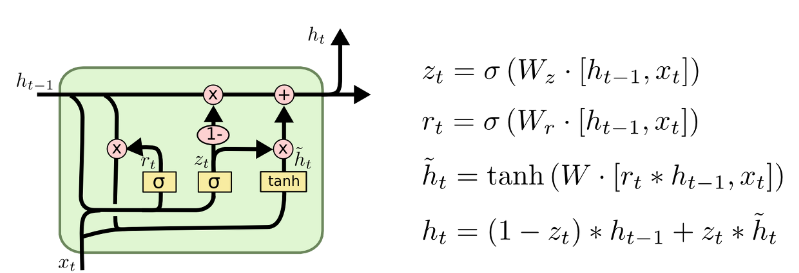

## 순서
1. 데이터 다운로드
2. 데이터 정제
3. 데이터 토큰화
4. 모델 설계
5. 학습
6. 문장 생성

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from konlpy.tag import Mecab

import time
import re 
import os 
import io 


print(tf.__version__)

2.4.1


### Step 1. 데이터 다운로드
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

```python
$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
```

In [2]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'
path_to_file2 = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.en'


with open(path_to_file, "r") as f:
    ko = f.read().splitlines()

print("ko_Data Size:", len(ko))

print("\n")

for ko_sen in ko[0:100][::20]: print(">>", ko_sen)

ko_Data Size: 94123


>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [3]:
with open(path_to_file2, "r") as f:
    en = f.read().splitlines()

    
print("en_Data Size:", len(en))

print("\n")

for en_sen in en[0:100][::20]: print(">>", en_sen)

en_Data Size: 94123


>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


데이터의 길이를 확인해 본다.

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


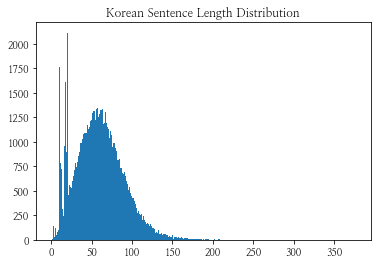

In [4]:
min_len = 999
max_len = 0
sum_len = 0

for ko_sen in ko:
    length = len(ko_sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(ko))

sentence_length = np.zeros((max_len), dtype=np.int)

for ko_sen in ko:
    sentence_length[len(ko_sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Korean Sentence Length Distribution")
plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 605
문장의 평균 길이: 126


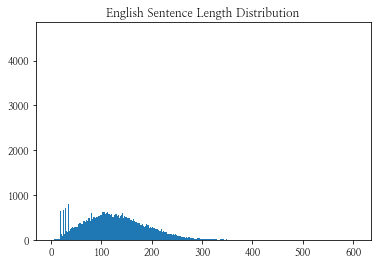

In [5]:
min_len = 999
max_len = 0
sum_len = 0

for en_sen in en:
    length = len(en_sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(en))

sentence_length = np.zeros((max_len), dtype=np.int)

for en_sen in en:
    sentence_length[len(en_sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("English Sentence Length Distribution")
plt.show()

### Step 2. 데이터 정제
1) set 데이터형이 __중복을 허용하지 않는다는 것을 활용__ 해 중복된 데이터를 제거하도록 합니다. 데이터의 __병렬 쌍이 흐트러지지 않게__ 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [6]:
cleaned_corpus = list(set(zip(ko, en)))
print("Data Size:", len(cleaned_corpus))

print(cleaned_corpus[:5])

Data Size: 78968
[('이번 영화에선 배우 레이 윈스턴은 새로운 인디아나 존스의 동료로 출연하며 존 허트와 짐 프로드벤트도 인디아나 존스의 동료로 캐스팅됐다.', 'Ray Winstone plays a new Indy ally, and the film also co-stars John Hurt and Jim Broadbent.'), ('친구들은“파르베즈가 지난해 애플우드 하이츠 고등학교에 입학했을 때는 히잡을 쓰고 다녔지만 히잡때문에 놀림을 받자 몇 달 전부터 쓰고 다니지 않았다"고 전했다.', 'According to her friends, Parvez wore the hijab when she started school at Applewood Heights last year. But after getting teased about the head scarf, she stopped wearing it a few months ago.'), ('그는 부시 행정부와 이란 정책에 대한 견해 차이 때문에 물러난 것은 아니라고 밝혔다.', 'Fallon, the head of U.S. Central Command, was the subject of a recent Esquire magazine profile that portrayed him as resisting pressure for military action against Iran, which the Bush administration accuses of trying to develop nuclear weapons.'), ('세비야는 이번 경기에서 전반에만 3골을 넣어 경기를 지배했다.', 'Double reigning UEFA Cup champions Sevilla had the match and the tie sewn up by half-time after romping into a 3-0 lead.'), ('바클레이스는 오늘 밤 리먼 브러더스의 북미 지역의 투자은행 업무와 자본 시장에 대한 투자

In [7]:
print(cleaned_corpus[0][0])

이번 영화에선 배우 레이 윈스턴은 새로운 인디아나 존스의 동료로 출연하며 존 허트와 짐 프로드벤트도 인디아나 존스의 동료로 캐스팅됐다.


In [8]:
print(cleaned_corpus[0][1])

Ray Winstone plays a new Indy ally, and the film also co-stars John Hurt and Jim Broadbent.


2) 앞서 정의한 preprocessing() 함수는 한글에 대해 동작하지 않습니다. __한글에 적용할 수 있는 정규식__ 을 추가하여 함수를 재정의하세요!

3) 타겟 언어인 영문엔 ```<start>``` 토큰과 ```<end>``` 토큰을 추가하고 split() 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. KoNLPy가 설치되어 있지 않다면 아래 문서를 참고해 설치해 주세요.

[설치하기-KoNLPy](https://konlpy.org/ko/latest/install/#ubuntu)


In [9]:
# 데이터 전처리

def preprocess_sentence(sentence, s_token=False, e_token=False):
    mecab = Mecab()
    sentence = sentence.lower().strip()   # 소문자  변경, 문장 양 옆의 빈칸 삭제
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   # '?.!,' 앞 뒤에 빈 칸 넣어주기
    sentence = re.sub(r'[" "]+', " ", sentence)   # 두 칸 이상 빈칸이면 1칸으로 바꾸기 
    sentence = re.sub(r"[^a-zA-Zㄱ-하-ㅣ가-힣0-9?.!,]+", " ", sentence)  # 한글과 '?.!,' 외에는 빈칸으로 바꾸기

    sentence = sentence.strip()  # 문장 양 옆의 빈칸 삭제
    
    if s_token == True and e_token == True:
        sentence = '<start> ' + sentence    
        sentence += ' <end>'
    
        sentence = sentence.split() # 공백 기반 토큰화
    
    else: 
        sentence = mecab.morphs(sentence)  # 형태소 기반 토큰화
    
    return sentence

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 __토큰의 길이가 40 이하__ 인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

- 토큰의 길이를 40으로 하면 훈련시킬 때 에러 메시지가 나와서 20으로 줄여주었다.

In [10]:
# cleaned_corpus로부터 토큰의 길이가 40 이하 인 데이터를 선별하여 
# eng_corpus와 kor_corpus를 각각 구축하세요.enc_corpus = []

kor_corpus = []
eng_corpus = []

for i in range(len(cleaned_corpus)):
    ko_sen = preprocess_sentence(cleaned_corpus[i][0])
    en_sen = preprocess_sentence(cleaned_corpus[i][1], s_token=True, e_token=True)
    if len(ko_sen) <= 20 and len(en_sen) <= 20:
        kor_corpus.append(ko_sen)
        eng_corpus.append(en_sen)
        
    
print('Korean:', kor_corpus[100])
print('English:', eng_corpus[100])

Korean: ['섬', '의', '48', '가', '상업', '용', ',', '주거', '용', ',', '그리고', '산업', '용', '으로', '이용', '되', '고', '있', '다', '.']
English: ['<start>', 'about', '48', 'of', 'the', 'island', 'is', 'used', 'for', 'commercial', ',', 'residential', 'and', 'industrial', 'purposes', '.', '<end>']


In [11]:
print('Korean:', kor_corpus[0])
print('English:', eng_corpus[0])

Korean: ['제', '가', '산출', '해낼', '수', '있', '는', '통계', '치', '는', '500', '만', '분', '의', '1', '입니다', '.']
English: ['<start>', 'the', 'statistics', 'i', 'could', 'come', 'up', 'with', 'were', 'about', '1', 'in', '5', 'million', '.', '<end>']


In [12]:
print(len(kor_corpus), len(eng_corpus))

14216 14216


### Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.


In [13]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='') # 모듈 클래스 사용
    
    tokenizer.fit_on_texts(corpus)  # 문자 데이터를 입력 받아 리스트의 형태로 반환
    
    tensor = tokenizer.texts_to_sequences(corpus) # 텍스트 안 단어를 숫자 시퀀스로 변환
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

- tf.keras.preprocessing.text.Tokenizer(num_words = 100)    
문장에서 단어를 토큰화하고 숫자에 대응시키는 딕셔너리 사용 가능, num_words 파라미터를 사용해 단어의 개수 제한 가능

- tokenizer.word_index
단어와 숫자의 키-값 쌍을 포함하는 딕셔너리를 반환

- tokenizer.texts_to_sequences(corpus)       
텍스트 안의 단어를 숫자 시퀀스의 형태로 변환시킴


In [14]:
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 17628
English Vocab Size: 15965


In [15]:
print(enc_tensor[:1])

[[ 290   14 8668 8669   43   13    3 4575  842    3  744   49  268    6
    65   50    1    0    0    0]]


In [16]:
for idx, word in enumerate(enc_tokenizer.word_index):
    print(idx, ":", word)
    
    if idx > 10: break

0 : .
1 : 다
2 : 는
3 : 이
4 : 은
5 : 의
6 : 을
7 : 에
8 : 했
9 : 를
10 : ,
11 : 하


In [17]:
for idx, word in enumerate(dec_tokenizer.word_index):
    print(idx, ":", word)
    
    if idx > 10: break

0 : <start>
1 : <end>
2 : .
3 : the
4 : ,
5 : to
6 : of
7 : a
8 : in
9 : and
10 : s
11 : is


### Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 __Attention 기반 Seq2seq 모델__ 을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! __Embedding Size와 Hidden Size__ 는 실험을 통해 적당한 값을 맞춰 주도록 합니다!


In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)    # W_encoder X H_encoder
        h_dec = tf.expand_dims(h_dec, 1)   # 차원 맞추기 
        h_dec = self.w_dec(h_dec)    # W_decoder X H_decoder

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)  # 어텐션 가중치

        context_vec = attn * h_enc  # 인코더의 hidden sate에 softmax 점수를 곱함
        context_vec = tf.reduce_sum(context_vec, axis=1)  # 위에서 구한 얼라먼트 벡터를 합침

        return context_vec, attn     # 컨텍스트 벡터와 어텐션 가중치

모델은 GRU를 사용했고 아래의 그림과 동일한 구조를 갖는 Encoder와 Decoder 클래스를 설계하였다.

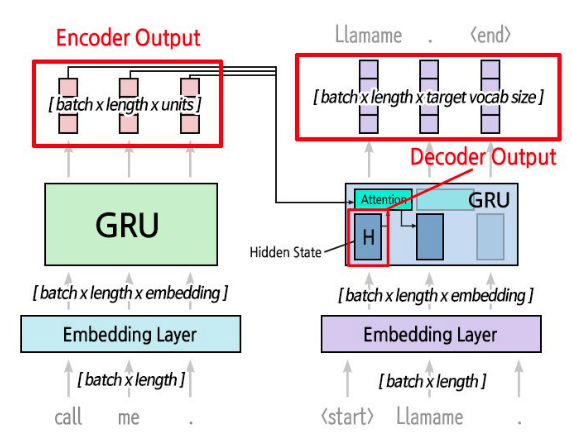

In [19]:
# Encoder는 모든 time-step의 hidden state 출력

class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [20]:


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        # 현재 시점의 입력: 바다나우 어텐션으로 구한 컨텍스트 벡터와 현재 시점 입력 단어의 임베딩을 연결
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        # gru를 통과하면 현재 시점 은닉상태와 번역 결과가 나옴.  
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))  # -1을 넣었으므로 자동으로 만들기
        out = self.fc(out)

        return out, h_dec, attn

In [21]:
# 코드를 실행하세요.

BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 하이퍼파라미터
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1  # 하이퍼파라미터

units         = 1024
embedding_dim = 1024  # 하이퍼파라미터

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))  # Outputs random values from a uniform distribution.
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 30, 1024)
Decoder Output: (32, 15966)
Decoder Hidden State: (32, 1024)
Attention: (32, 30, 1)


### Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 __가장 멋지게 번역한 Case__ 를 제출하세요! (__Attention Map을 시각화__ 해보는 것도 재밌을 거예요!)

참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

```python
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
```

![](https://images.velog.io/images/guide333/post/cef2afd7-3d97-4228-b62e-2f52838b7d31/Screenshot%20from%202021-04-16%2017-13-19.png)

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

##### Loss
Encoder-Decoder 구조는 입출력이 복잡해 학습 과정을 직접 정의해야 한다. 
- SparseCategoricalCrossentropy(from_logits=True, reduction='none')   
모델이 출력한 확률 분포와 One-hot 인코딩이 아닌 정수 인덱스 답안을 비교해 Cross Entropy 값을 구한다. (참고: One-hot 인코딩인 경우는 ```CategoricalCrossentropy()``` 사용)    
```from_logits =True```는 확률 분포가 모델의 출력값 그대로 전달한다. False라면 확률 분포가 softmax를 거쳐 들어온다. 

- mask    
모델에게 \<pad> 토큰이 패딩을 위한 토큰이라고 명시하지 않으면 모델은 \<pad> 토큰만 생성할 확률이 높아진다. mask를 사용해 정답지에서 \<pad> 토큰을 찾아 그 부분의 Loss를 구하지 않도록 한다. equal() 함수에  \<pad> 토큰의 인덱스를 전달해야 하지만 대부분 0으로 패딩되므로 편의상 0으로 전달해 처리했다.

- tf.math.equal(x, y, name=None)     
원소 별로 (real == 0)인 값을 true, false로 반환

- tf.math.logical_not(x, name=None)    
원소 별로 x가 아닌 것을 true, false로 답

- tf.cast(x, dtype, name=None)   
true = 1, false=0로 출력

- tf.reduce_mean(loss_object)   
모든 원소의 합을 원소 개수로 나눠 평균을 구한다. 


In [23]:
@tf.function       # 훈련 속도 가속    
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]  # 배치 사이즈
    loss = 0

    with tf.GradientTape() as tape:   # 학습 시 발생한 모든 연산 기록하는 테이프(예측과 손실 계산)
        enc_out = encoder(src)          # 컨텍스트 벡터 enc_out 생성
        h_dec = enc_out[:, -1]    # t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의
        
        # Decoder에 입력으로 전달할 <start> 토큰 문장 생성
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)  # pred: <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. 

            loss += loss_function(tgt[:, t], pred)   # 예측된 단어와 정답 간의 Loss를 구하기
            dec_src = tf.expand_dims(tgt[:, t], 1)   # t=1의 정답 단어를 다음 입력으로 사용
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)  # 그래디언트 계산
    optimizer.apply_gradients(zip(gradients, variables)) # 오차역전파 - 가중치 업데이트
    
    return batch_loss


In [24]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))  # 각 배치의 시작 인덱스를 idx_list 배열에 저장
    random.shuffle(idx_list)  # 학습이 원할하도록 데이터 섞기, 인덱스를 섞음
    t = tqdm(idx_list)    # tqdm

    # 각 미니배치를 train_step() 함수에서 학습 
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

  0%|          | 0/445 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

Epoch 30: 100%|██████████| 445/445 [01:45<00:00,  4.23it/s, Loss 0.1507]


In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')  # 2차원 행렬/배열을 컬러 이미지로 나타냄

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) # 1씩 눈금 그리기
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama s camp touted a big boost for new era of obama to be more likeable . <end> 


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


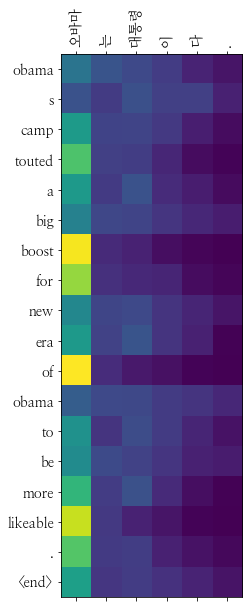

In [26]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: there are a local autonomy , the country . <end> 


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


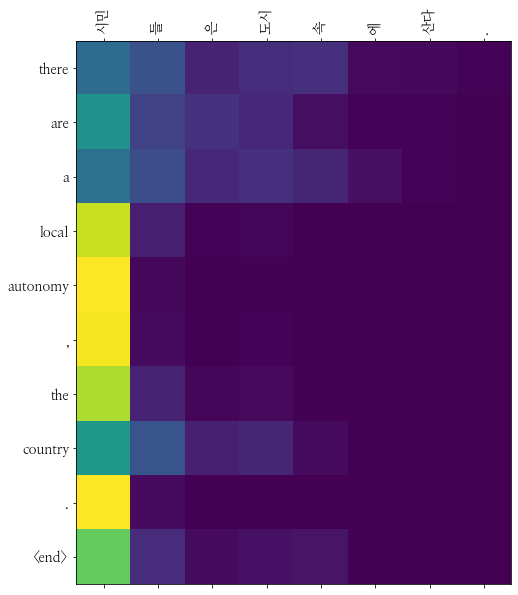

In [27]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the referee no chance . <end> 


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


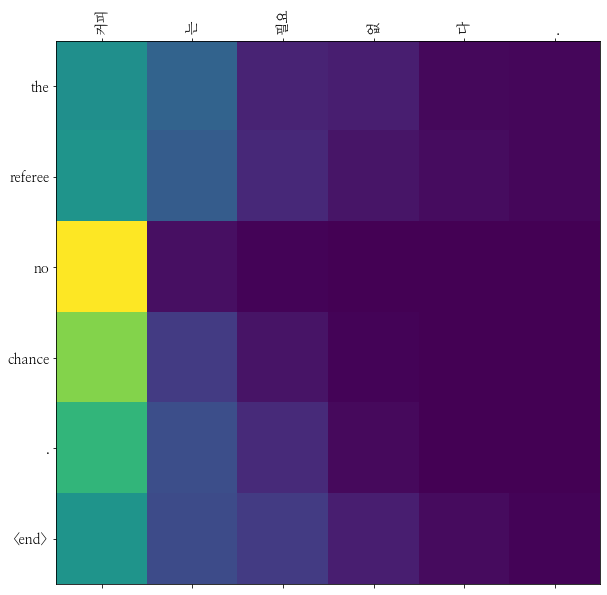

In [28]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: four children . <end> 


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


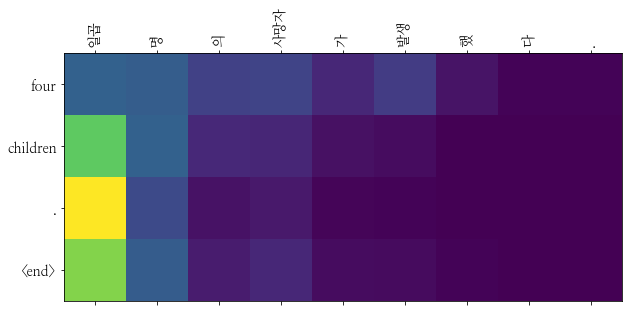

In [29]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

### 결과
- padding='pre'로 했을 때, loss가 4.7에서 2.3으로 post보다 덜 떨어졌고, 번역도 모두 같게 나왔다. padding이 pre일 때 더 좋은 결과가 나온다고 알려져 있는데, 이번 모델에서는 왜 post가 더 좋은 결과가 나왔는지 궁금하다. 
- 하이퍼파라미터를 조절해보아도 좋은 번역 결과가 나오지 않는다. 
- 에폭을 늘려서 Loss가 많이 줄어도 좋은 결과가 나오지 않는다.
- units=521로 할 때마다 loss의 변화가 없고 문장이 생성되지 않았다. 

### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|	상세기준||
|:------:|:--------:|:--------:|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|Y|
|2. Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|Y|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.| N|


## 후기
### 이번 프로젝트에서 어려웠던 점
- 처음 모델을 돌렸을 때 결과가 아예 나오지 않아 프로젝트를 처음부터 다시 해야 했다. 어느 부분이 잘못된 것인지는 찾지 못해 아쉽다.

### 프로젝트를 진행하면서 알게된 점
- 바다나우 어텐션
- GRU
- SparseCategoricalCrossentropy()

### 프로젝트를 진행하면서 아직 모호한 점
- 손실함수에서 패딩을 마스크하는 부분
- 학습과 평가 부분의 코드

### 자기 다짐
코드가 길고 어려워져 이해하는데 시간이 오래 걸렸다. 그러나 아직도 잘 이해하지 못하는 부분이 있다. 코드 공부를 열심히 하려고 하지만 해야할 공부가 많아서 항상 부족함을 느낀다. 

- 참고    
[Attn: Illustrated Attention](https://eda-ai-lab.tistory.com/157)   
https://it-ist.tistory.com/27
